In [1]:
#数据预处理
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
from time import time
from scipy.signal import welch
from scipy.interpolate import  interp1d as interp
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedKFold 
from tensorflow.keras.utils import Progbar
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
class Preprocessing(object):
    """
    对序列进行提取特征等预处理
    为了可能处理变长序列,因此输入为list
    """
    def __init__(self,with_label=True):
        self.with_label=with_label
    def __call__(self,sequence):
        for i in range(len(sequence)):
            time_point=np.expand_dims(sequence[i][0],axis=0)
            if self.with_label:
                label=np.expand_dims(sequence[i][-1],axis=0)
                new_sequence=self.for_each(sequence[i][1:-1])
                sequence[i]=np.concatenate([time_point,new_sequence,label],axis=0)
            else:
                new_sequence=self.for_each(sequence[i][1:])
                sequence[i]=np.concatenate([time_point,new_sequence],axis=0)
        sequence=self.for_all(sequence)
        return sequence
    def smooth(self,array,decay_rate=0.9):
        _smooth=np.zeros(array.shape)
        for i in range(1,len(array)-1):
            decay=min(decay_rate,(i+1)/(i+10))
            _smooth[i]=_smooth[i-1]*decay+(1-decay)*array[i]
        return _smooth
    def for_all(self,sequence):#变长序列可以numpy吗#
        return sequence
        mean=np.zeros(shape=sequence[0].shape[0])
        std=np.zeros(shape=sequence[0].shape[0])
        lenth=len(sequence)
        for index in range(lenth):
            if self.with_label:
                _range=range(1,sequence[index].shape[0]-1)
            else:
                _range=range(1,sequence[index].shape[0])
            for i in _range:
                mean[i]+=sequence[index][i].mean()/lenth
                std[i]+=sequence[index][i].std()/lenth
        for index in range(lenth):
            if self.with_label:
                _range=range(1,sequence[index].shape[0]-1)
            else:
                _range=range(1,sequence[index].shape[0])
            for i in _range:
                sequence[index][i]=(sequence[index][i]-mean[i])/std[i]
        return sequence
    def for_each(self,sequence):
        acc=(sequence[0]**2+sequence[1]**2+sequence[2]**2)**0.5
        acc=np.expand_dims(acc,axis=0)
        acc_g=(sequence[3]**2+sequence[4]**2+sequence[5]**2)**0.5
        acc_g=np.expand_dims(acc_g,axis=0)
        sequence=np.concatenate([sequence,acc,acc_g],axis=0)
        return sequence

In [2]:
#加载数据
class DatasetLoader(object):
    def __init__(self,csv_file,with_label=True,num_classes=19):
        self.csv_file=csv_file
        self.with_label=with_label
        self.format="channel_last"
        self.split=False
        self.names=self.get_feature_names()
        self.num_classes=num_classes
        self.data_split=False
    def get_feature_names(self):
         with open(self.csv_file) as f:
            examples={}
            names=f.readline().split(',')[1:]
            names[-1]=names[-1][:-1]
            return names
    def make_numpy(self,num_interpolation=200,with_label=True):
        '''将数据读取并保存为Numpy数组
               Args:
                 num_interpolation:差值法采样点个数
                 with_label：是否带标签
               Returns:
                 A list,shape=[num_examples,keys,length]
        '''
        #数据读取
        if self.csv_file is None:
            raise ValueError("sub dataset cannnot get numpy data")
        print("Loading date...")
        line={}
        with open(self.csv_file) as f:
            examples={}
            names=f.readline().split(',')[1:]
            names[-1]=names[-1][:-1]
            while True:
                try:
                    line=f.readline().split(",")
                    if line is None:
                        break
                    for i in range(len(line)):
                        line[i]=eval(line[i])
                    if not line[0] in examples:
                        examples[line[0]]=[]
                    examples[line[0]].append(line[1:])
                except:
                    break
        print("done")
        #格式转换            
        for i in range(len(examples)):
            examples[i]=np.array(examples[i]).transpose([1,0])
        self.examples=examples=list(examples.values())
        return self
    def resample(self,num_interpolation=200):
        examples=self.examples
        print("interpolate")
        bar=Progbar(len(examples))#进度条
        if num_interpolation and num_interpolation is not None:
            for i in range(len(examples)):
                range_len=examples[i][0][-1]-examples[i][0][0]
                range_start=examples[i][0][0]
                range_interval=range_len/num_interpolation
                interp_x=[range_start+range_interval*i for i in range(num_interpolation)]
                interp_data=[interp_x]
                for feature_id in range(1,len(self.names)):
                    try:
                        interp_f=interp(examples[i][0],examples[i][feature_id],kind="cubic")
                        interp_data.append([interp_f(x)for x in interp_x])
                    except:
                        raise ValueError("%d %d"%(i,feature_id),examples[i])
                bar.update(i)
                examples[i]=np.array(interp_data)
        print("\ndone")
        #数据预处理
        preprocession=Preprocessing(with_label=self.with_label)
        examples=preprocession(examples)
        self.examples=np.array(examples,dtype="float32")    
        if self.with_label:
            self.y=self.examples[::,-1,0].tolist()
            self.x=self.examples[::,1:-1,::]
        else:
            self.x=self.examples[::,1:,::]
        return self
    def apply_class_weights(self):
        weights=np.zeros([self.num_classes])
        for i in range(len(weights)):
            weights[i]=(self.examples[::,-1:,0]==i).sum()
        return weights/weights.sum()
    def data_format(string="channel_last"):
        if not string in ["channel_first","channel_last"]:
            raise ValueError("either channel_last or channel_first are supported")
        self.format=string
    def apply_data(self):
        if self.with_label:
            if self.split:
                if self.format=="channel_first":
                    return self.x_train,self.y_train,self.x_test,self.y_test
                else:
                    return self.x_train.transpose([0,2,1]),self.y_train,self.x_test.transpose([0,2,1]),self.y_test
                    
            else:
                if self.format=="channel_first":
                    return self.x,self.y
                else:
                    return self.x.transpose([0,2,1]),self.y
        else:
            if self.format=="channel_first":
                return self.x
            else:
                return self.x.transpose([0,2,1])
if False:
    train_csv_file="data\\sensor_train.csv"
    test_csv_file="data\\sensor_test.csv"

    dataset=DatasetLoader(train_csv_file)
    print(dataset.names)
    data=dataset.make_numpy()
    data=dataset.resample(num_interpolation=60)
    x_train,y_train=data.apply_data()

plt.plot(x_train[5,::,8])


NameError: name 'x_train' is not defined

In [3]:
#metrics
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
def single_score(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0
def py_score(y_true,y_pred):
    y_true=np.argmax(y_true,axis=-1)
    y_pred=np.argmax(y_pred,axis=-1)
    scores=[]
    for i in range(len(y_true)):
        scores.append(single_score(y_true[i],y_pred[i]))
    mean_score=np.array(scores,dtype="float32").mean()
    return mean_score,mean_score
def score(y_true,y_pred):
    """线上评测所使用的评测方法
    Args:
      y_true:one_hot编码的标签
      y_pred:网络类别置信度预测
    Returns:
      Tensor标量
    """
    mean_score=tf.py_func(py_score,[y_true,y_pred],[tf.float32,tf.float32])[0]
    return tf.reshape(mean_score,shape=())

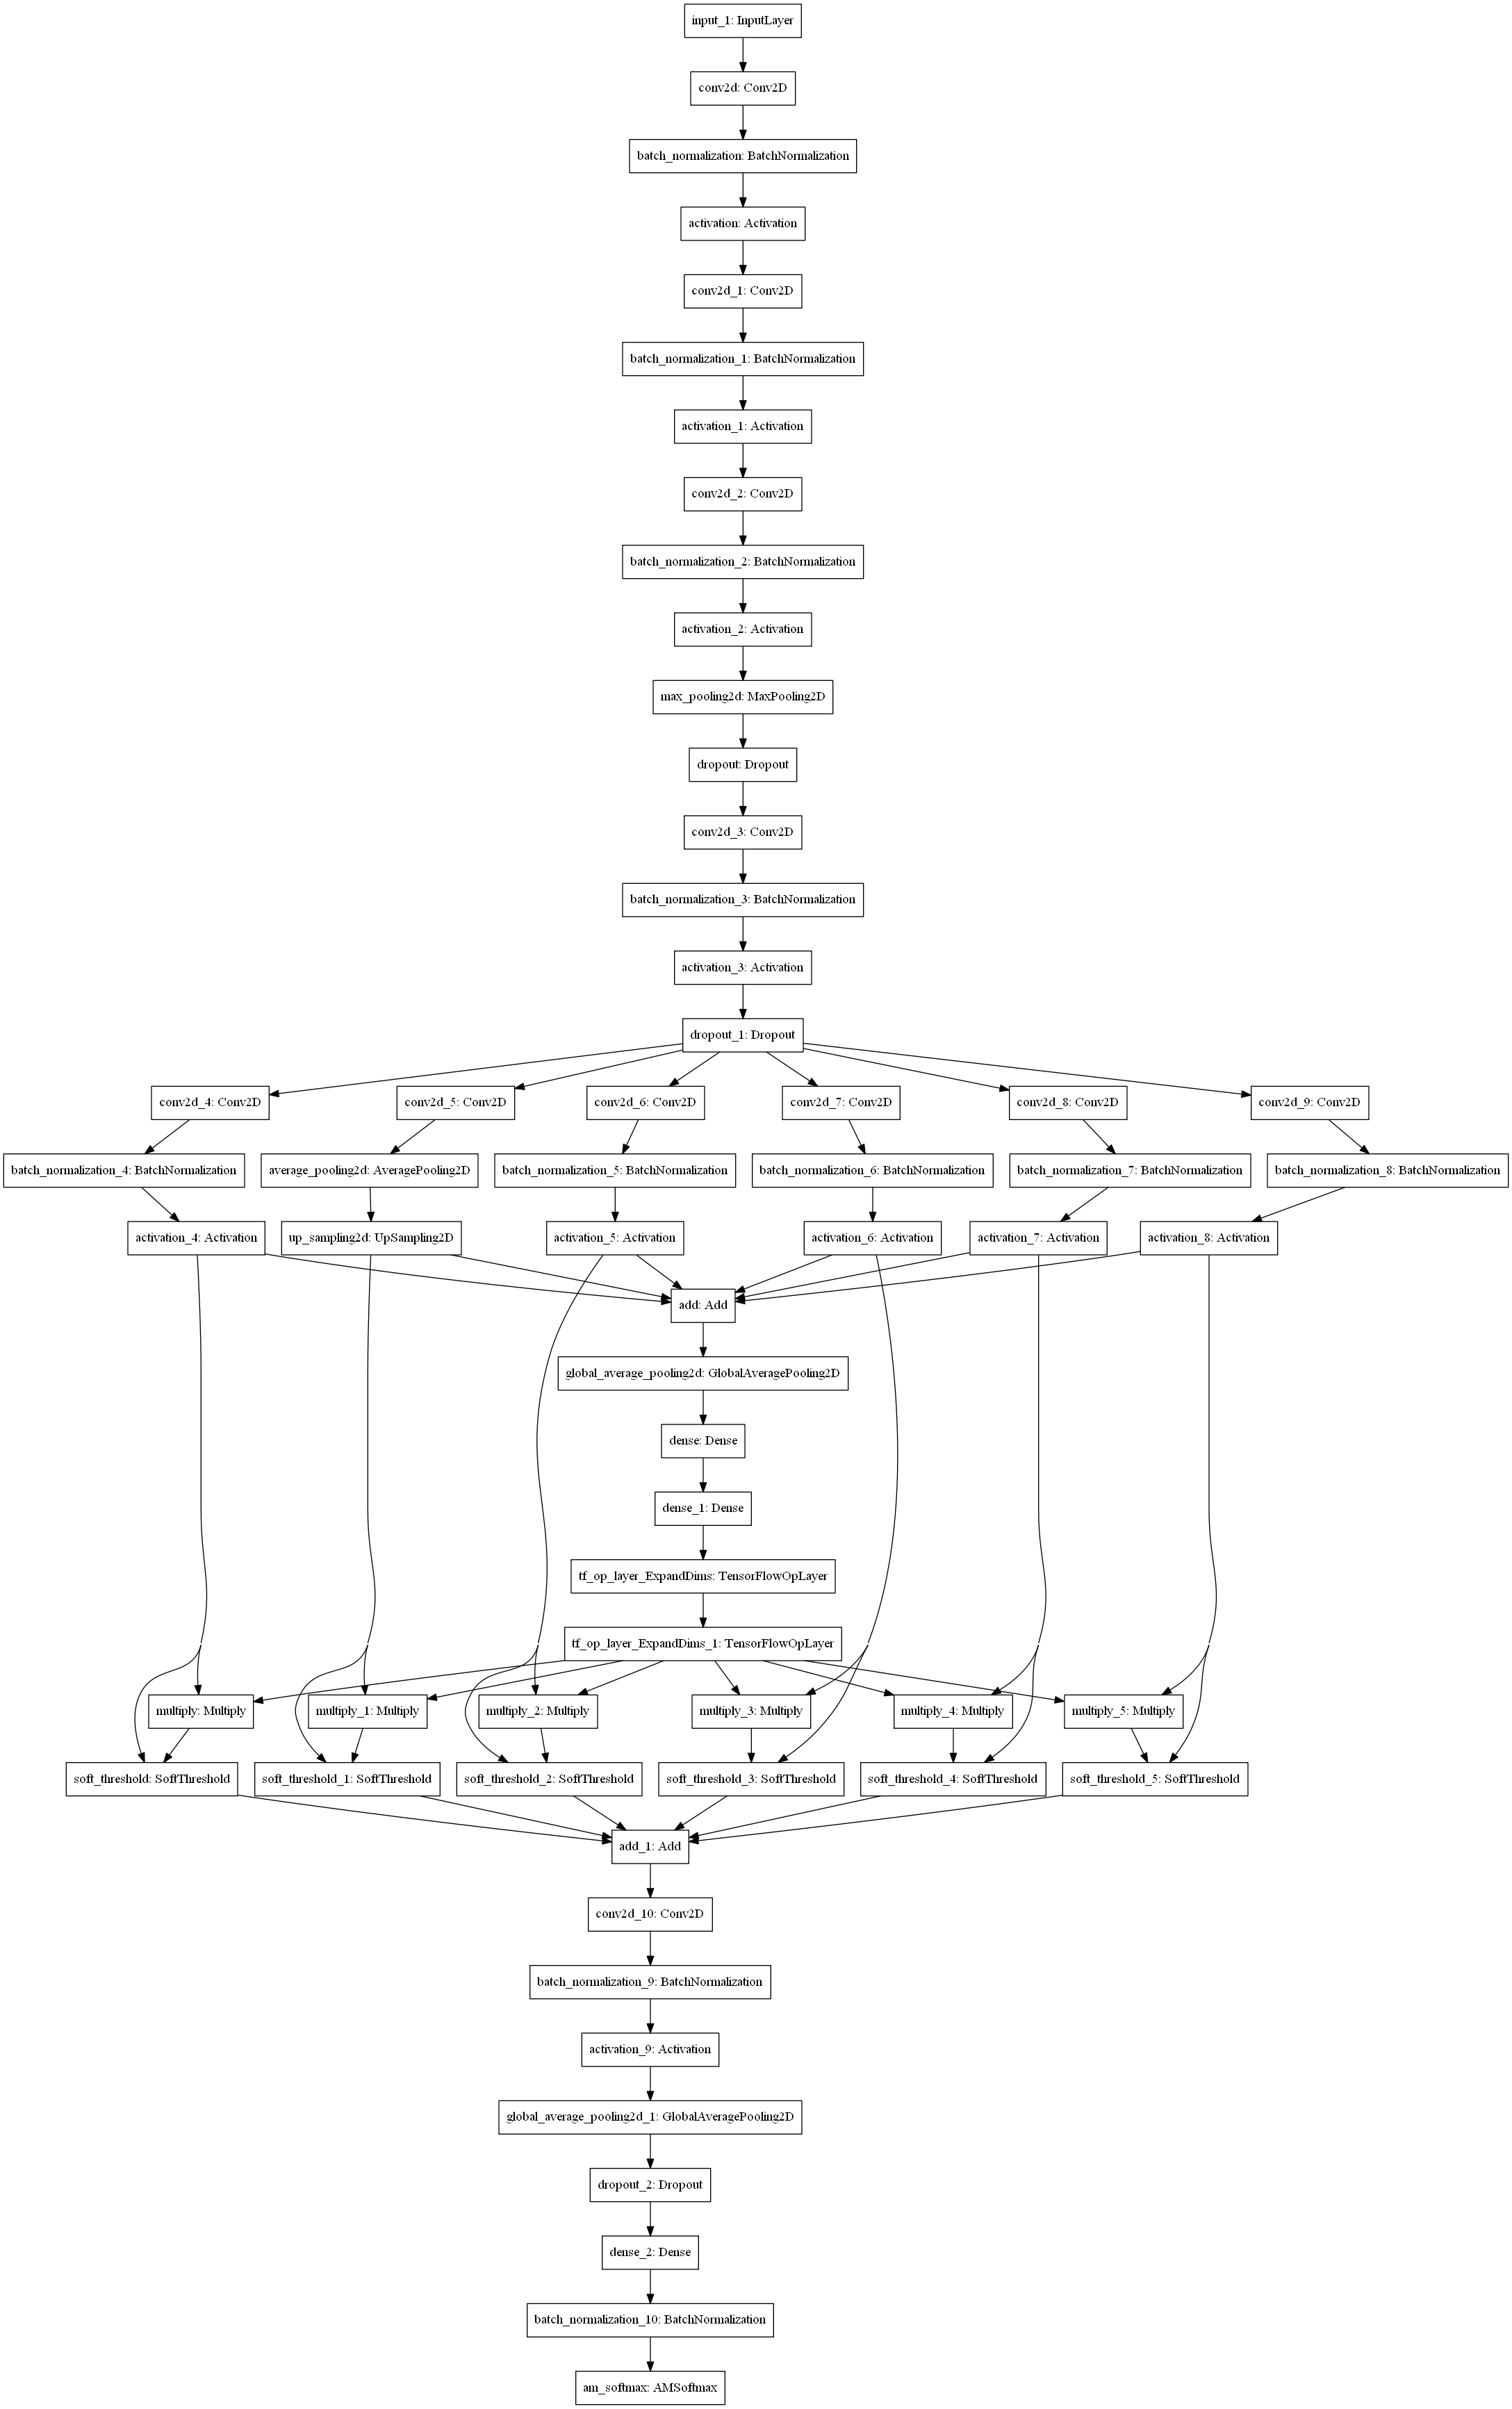

In [35]:
#网络结构
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from extend import WeightDecayScheduler,AdamW
tf.reset_default_graph()
class SoftThreshold(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(SoftThreshold,self).__init__(**kwargs)
    def call(self,inputs):
        tensor=inputs[0]
        threshold=inputs[1]
        threshold=tf.abs(threshold)
        less=tf.cast(tf.less(tensor,-threshold),tf.float32)
        greater=tf.cast(tf.greater(tensor,threshold),tf.float32)
        tensor=(tensor-threshold)*greater+(tensor+threshold)*less
        return tensor
class SKNet(object):
    def __init__(self,filters,kernel_size,activation,dilation_rates=[1,1,1,1]):
        self.filters=filters
        self.kernel_size=kernel_size
        self.dilation_rates=dilation_rates
        self.activation=activation
        self.sk_rate=16
    def branch(self,tensor,dilation_rate):
        x=Conv2D(self.filters,self.kernel_size,1,padding="same",kernel_regularizer=l2(0.00),
                 activation=self.activation,dilation_rate=dilation_rate)(tensor)
        x=BatchNormalization()(x)
        x=Activation(self.activation)(x)
        return x
    def attention(self,tensor):
        add=tf.keras.layers.add(tensor)
        shape=add.shape.as_list()
        squeeze=GlobalAveragePooling2D()(add)
        squeeze=Dense(shape[-1]//self.sk_rate,activation=tf.nn.relu)(squeeze)
        extract=Dense(shape[-1],activation=tf.nn.softmax)(squeeze)
        extract=tf.expand_dims(extract,axis=1)
        extract=tf.expand_dims(extract,axis=1)
        output=[]
        for t in tensor:
            threshold=tf.keras.layers.multiply([t,extract])
            output.append(SoftThreshold()([t,threshold]))
        return output
    def pool(self,tensor):
        tensor=Conv2D(self.filters,self.kernel_size,1,padding="same",kernel_regularizer=l2(0.00))(tensor)
        shape=tensor.shape.as_list()#[batch,lenth,channels]
        scaler=AveragePooling2D((shape[1],shape[2]))(tensor)#[batch,channels]
        scaler=UpSampling2D((shape[1],shape[2]))(scaler)
        return scaler
    def __call__(self,tensor):
        x=Conv2D(self.filters,1,1,padding="same",
                 activation=self.activation,kernel_regularizer=l2(0.00))(tensor)
        x=BatchNormalization()(x)
        x=Activation(None)(x)
        output=[x]
        output.append(self.pool(tensor))
        for rate in self.dilation_rates:
            output.append(self.branch(tensor,rate))
        output=self.attention(output)
        output=tf.keras.layers.add(output)
        output=Conv2D(self.filters,3,1,padding="same",kernel_regularizer=l2(0.00))(output)
        output=BatchNormalization()(output)
        output=Activation(self.activation)(output)
        return output
class AMSoftmax(tf.keras.layers.Layer):
    def __init__(self, units=19,s=30,m=0.25,
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=tf.keras.regularizers.l2(0),
                 kernel_constraint=None,
                 **kwargs):
        super(AMSoftmax, self).__init__(**kwargs)
        self.units = units
        self.s = s
        self.m = m
        self.kernel=None
        self.kernel_initializer=tf.keras.initializers.get(kernel_initializer)
        self.kernel_regularizer=tf.keras.regularizers.get(kernel_regularizer)
        self.kernel_constraint=tf.keras.constraints.get(kernel_constraint)
        self.supports_masking=True
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.bias = None
        self.built = True
    def call(self,inputs,**kwargs):
        inputs=tf.nn.l2_normalize(inputs,axis=-1)
        self.kernel=tf.nn.l2_normalize(self.kernel,dim=(0, 1))   # W归一化
        dis_cosin=K.dot(inputs, self.kernel)
        psi=dis_cosin-self.m
        e_costheta=K.exp(self.s*dis_cosin)
        e_psi=K.exp(self.s*psi)
        sum_x=K.sum(e_costheta,axis=-1,keepdims=True)
        temp=e_psi-e_costheta
        temp=temp+sum_x
        output=e_psi/temp
        return output
    def get_config(self):
        config = super(AMSoftmax, self).get_config()
        config.update(
            {
                's':self.s,
                'm':self.m,
                'kernel':self.kernel,
                'kernel_initializer':self.kernel_initializer,
                'kernel_regularizer':self.kernel_regularizer,
                "kernel_constraint":sef.constraint,
                "supports_masking":self.supports_masking
             }
        )
        return config
def CNN(inputs,num_classes):
    x=Conv2D(32,3,1,padding="same",kernel_regularizer=l2(0.00))(inputs)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=Conv2D(64,3,1,padding="same",kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=Conv2D(128,3,1,padding="same",kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    
    x=MaxPooling2D(2,padding="same")(x)
    x=Dropout(0.5)(x)
    
    x=Conv2D(192,3,1,padding="same",kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=Activation(tf.nn.relu)(x)
    x=Dropout(0.5)(x)
    
    x=SKNet(384,3,activation=tf.nn.relu)(x)
    
    x=GlobalAveragePooling2D()(x)
    x=Dropout(0.5)(x)

    x=Dense(num_classes,kernel_regularizer=l2(0.00))(x)
    x=BatchNormalization()(x)
    x=AMSoftmax()(x)
    return x
inputs=Input(shape=[64,8,1])
outputs=CNN(inputs,num_classes=19)
tf.keras.utils.plot_model(Model(inputs,outputs),show_shapes=False)

In [5]:
#加载数据和模型
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
tf.reset_default_graph()
csv_file="data\\sensor_train.csv"
test_csv_file="data\\sensor_test.csv"
filepath='best_weights_aspp_raw'
batch_size=64
config=tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.Session(config=config)
K.set_session(sess)
if True:
    dataset=DatasetLoader(csv_file,with_label=True,num_classes=19)
    dataset=dataset.make_numpy()
    dataset=dataset.resample(num_interpolation=64)
    x,y=dataset.apply_data()
    class_weight=dataset.apply_class_weights()
    dataset=DatasetLoader(test_csv_file,with_label=False)
    data=dataset.make_numpy()
    data=dataset.resample(num_interpolation=64)
    x_val=data.apply_data()
    x=np.expand_dims(x,axis=-1)
    x_val=np.expand_dims(x_val,axis=-1)
x.shape

Loading date...
done
interpolate
7291/7292 [============================>.] - ETA: 0s
done
Loading date...
done
interpolate
7495/7500 [============================>.] - ETA: 0s
done


(7292, 64, 8, 1)

In [50]:
class_weight

array([0.03304992, 0.09270433, 0.05608886, 0.04552935, 0.05965442,
       0.04703785, 0.10175535, 0.03236423, 0.0449808 , 0.0393582 ,
       0.03236423, 0.06157433, 0.10065826, 0.03990675, 0.01727921,
       0.06555129, 0.04731212, 0.03551838, 0.04731212])

In [36]:
from tensorflow.keras.utils import to_categorical
config=tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.Session(config=config)
K.set_session(sess)
kfold = StratifiedKFold(5, shuffle=True,random_state=12255877)
proba_t = np.zeros((7500, 19))
train_score=[]
test_score=[]
for fold,(xx,yy) in enumerate(kfold.split(x,y)):
    tf.reset_default_graph()
    inputs=Input(shape=[64,8,1])
    outputs=CNN(inputs,num_classes=19)
    model=Model(inputs=inputs,outputs=outputs)
    _y=to_categorical(y,19)
    plateau = ReduceLROnPlateau(monitor="val_score",
                                verbose=1,
                                mode='max',
                                factor=0.5,
                                patience=30)
    early_stopping = EarlyStopping(monitor='val_acc',
                                   verbose=1,
                                   mode='max',
                                   patience=60)
    checkpoint = ModelCheckpoint(f'aspp_baseline{fold}.h5',
                                 monitor='val_score',
                                 verbose=1,
                                 mode='max',
                                 save_best_only=True)
    weight_decay=WeightDecayScheduler(init_lr=0.001)
    model.compile(loss="categorical_crossentropy",optimizer=AdamW(lr=0.001,weight_decay=6e-4),metrics=["acc",score])
    trained_model=model.fit(
            x[xx],
            _y[xx],
            batch_size=batch_size,
            class_weight=(1-class_weight)**2,
            shuffle=True,
            validation_data=(x[yy],_y[yy]),
            epochs=800,
            callbacks=[plateau,early_stopping,checkpoint,weight_decay])
    model.load_weights(f'aspp_baseline{fold}.h5')
    proba_t += model.predict(x_val, verbose=0, batch_size=1024)/5.
    train_score.append(np.array(trained_model.history["score"]).max())
    test_score.append(np.array(trained_model.history["val_score"]).max())
label=proba_t.argmax(axis=1)
print("on_train_set:",np.array(train_score))
print("average:",np.array(train_score).mean())
print("on_test_set:",np.array(test_score))
print("average:",np.array(test_score).mean())
print("done")

Train on 5825 samples, validate on 1467 samples
0 1.0000000474974513
Epoch 1/800
5824/5825 [============================>.] - ETA: 0s - loss: 2.4538 - acc: 0.2565 - score: 0.3554
Epoch 00001: val_score improved from -inf to 0.27242, saving model to aspp_baseline0.h5


NameError: name 'sef' is not defined

In [11]:
print("on_train_set:",np.array(train_score))
print("average:",np.array(train_score).mean())
print("on_test_set:",np.array(test_score))
print("average:",np.array(test_score).mean())

on_train_set: [0.9955843  0.99118483 0.9907479  0.99437135 0.99428225]
average: 0.99323416
on_test_set: [0.87848437 0.8689438  0.8834407  0.8719805  0.871452  ]
average: 0.8748603


In [33]:
import pandas as pd
frame = pd.DataFrame(label)
frame.rename(columns={0:'behavior_id'},inplace = True)
frame.reset_index(inplace = True)
frame.rename(columns={'index':'fragment_id'},inplace = True)
frame.to_csv('submit_8748_9932.csv',index=False)

In [28]:
import pandas as pd
frame = pd.DataFrame(proba_t)
frame.rename(columns={},inplace = True)
frame.reset_index(inplace = True)
frame.rename(columns={'index':'fragment_id'},inplace = True)
frame.to_csv('submit_prob_87.48_99.32.csv',index=False)

In [29]:
frame

,fragment_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,0.014420,0.016472,0.013964,0.013519,0.011042,0.015903,0.018136,0.013285,0.014426,0.013726,0.011506,0.014985,0.651843,0.109354,0.007993,0.019716,0.012281,0.011608,0.015822
1,1,0.002437,0.004836,0.003582,0.933615,0.006504,0.003387,0.004030,0.003356,0.003720,0.003252,0.002808,0.003644,0.004728,0.003576,0.002593,0.004415,0.003248,0.002956,0.003311
2,2,0.017090,0.049845,0.027875,0.051762,0.023248,0.059604,0.444109,0.033741,0.023079,0.016552,0.012781,0.085432,0.020677,0.022336,0.016848,0.028282,0.024562,0.018295,0.023881
3,3,0.058978,0.011916,0.011727,0.012431,0.010695,0.009758,0.761800,0.009064,0.010818,0.011463,0.008786,0.011020,0.012706,0.008707,0.007223,0.011630,0.010686,0.010514,0.010076
4,4,0.005342,0.006408,0.004562,0.004455,0.005693,0.005576,0.006554,0.004351,0.004676,0.005030,0.004645,0.005619,0.004573,0.027953,0.003998,0.007828,0.005222,0.003317,0.884198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,7495,0.433359,0.006389,0.007722,0.444349,0.007002,0.006633,0.006090,0.006110,0.007059,0.007010,0.006715,0.011980,0.008224,0.007057,0.005247,0.007797,0.007013,0.006936,0.007308
7496,7496,0.006893,0.008273,0.006715,0.011101,0.007744,0.834953,0.009812,0.012513,0.006920,0.006190,0.006923,0.026563,0.009519,0.005990,0.005330,0.009893,0.007216,0.006500,0.010952
7497,7497,0.002612,0.000426,0.000341,0.000271,0.000308,0.000483,0.000816,0.000548,0.000497,0.000336,0.000587,0.000238,0.000219,0.000254,0.000345,0.990703,0.000459,0.000264,0.000293
7498,7498,0.004160,0.004875,0.004358,0.004144,0.004164,0.004114,0.005229,0.003972,0.004292,0.004021,0.003764,0.004512,0.923835,0.005681,0.003906,0.004563,0.003698,0.003063,0.003649
